# Example: $\hat{A}x=\hat{b}$
- want to solve $\hat{A}x=\hat{b}$
- $\hat{A}$ is so big that we can't work on it on a single machine
- split $\hat{A}$ into groups of rows
$$
\hat{A}x=\hat{b}
$$
$$
\begin{bmatrix}
-\ A_1 - \\
-\ A_2 - \\
-\ A_3 - 
\end{bmatrix}x =
\begin{bmatrix}
b_1 \\
b_2 \\
b_3
\end{bmatrix}
$$
- $\hat{A}x=\hat{b}$ equivalent to set intersection problem
$$
x \in \lbrace z \mid A_1z = b_1 \rbrace \cap \lbrace z \mid A_2z = b_2 \rbrace \cap \lbrace z \mid A_3z = b_3 \rbrace
$$
- i.e., find $x$ in the intersection of subspaces
- on each machine, **easy** to **project** onto its subspace:
$$
\begin{array}{ll}
\mbox{minimize} & \|x - x_0 \|_2^2 \\
\mbox{subject to} & A_i x = b_i
\end{array}
$$
- "easy" because it's just linear algebra; involves a matrix factorization that can be **reused** at each iteration
- let $\mbox{proj}_i(x_0)$ be the projection of $x_0$ onto the subspace
$$\lbrace z \mid A_iz = b_i \rbrace$$

# Projection

projection of $x_0$ onto $\lbrace x \mid Ax = b\rbrace$ given by
$$
\mbox{proj}(x_0) = \left(I - A^T (AA^T)^{-1}A\right)x_0 + A^T (AA^T)^{-1}b = \left(I - A^T (AA^T)^{-1}A\right)x_0 + c
$$

## One-time computation
- compute $AA^T$ and form its Cholesky factorization once to reuse at each iteration
- compute $c = A^T (AA^T)^{-1}b$ to reuse


# Iteration
- $z_i^{k+1} = \mbox{proj}_i(x^k)$
- $\bar{x}^{k+1} = \frac{1}{N} \sum_{i=1}^N z_i^{k+1}$
- the projection operation involves using the Cholesky factorization of $AA^T$ to compute $A^T (AA^T)^{-1}Ax^k$


In [1]:
import numpy as np
from scipy.linalg import cho_factor, cho_solve
%matplotlib inline
import matplotlib.pyplot as plt

def factor(A,b):
    """Return cholesky factorization data to project onto Ax=b."""
    AAt = A.dot(A.T)
    chol = cho_factor(AAt, overwrite_a=True)
    
    c = cho_solve(chol, b, overwrite_b=False)
    c = A.T.dot(c)
    
    proj_data = dict(A=A, b=b, chol=chol,c=c)
    
    return proj_data

def proj(proj_data, x0):
    """Use cholesky factorization data to project onto Ax=b."""
    A, chol, c = (proj_data[k] for k in 'A chol c'.split())

    x = A.dot(x0)
    x = cho_solve(chol, x, overwrite_b=True)
    x = A.T.dot(x)
    x = x0 - x + c
    return x

def average(*vals):
    """ Come to a consensus """
    return np.mean(vals, axis=0)

def make_data(k, rows, seed=0):
    """Make some random test data."""
    # each of k chunks gets 'rows' rows of the full matrix
    n = rows*k

    np.random.seed(seed)

    Ahat = np.random.randn(n,n)
    bhat = np.random.randn(n)

    x_true = np.linalg.solve(Ahat,bhat)

    x0 = np.random.randn(n)

    As = []
    bs = []

    for i in range(k):
        s = slice(i*rows,(i+1)*rows)
        As += [Ahat[s,:]]
        bs += [bhat[s]]
        
    return As, bs, x_true, x0

# Problem data
- this algorithm has the same flavor as the thing I'd like to do, but actually converges **very** slowly
- will take a very long time to converge anything other than the smallest examples
- don't worry if convergence plots look flat when dealing with 100s of rows

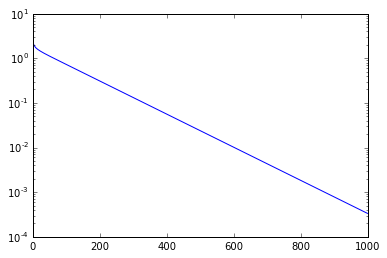

In [2]:
As, bs, x_true, x0 = make_data(4, 2, seed=0)

proj_data = list(map(factor, As, bs))

x = x0

r = []
for i in range(1000):
    z = (proj(d,x) for d in proj_data)
    x = average(*z)
    r.append(np.linalg.norm(x_true-x))
    
plt.semilogy(r)

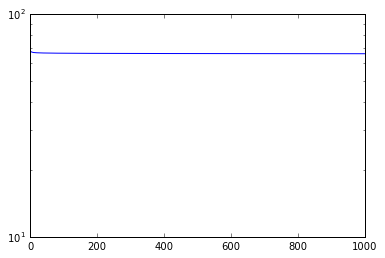

In [3]:
As, bs, x_true, x0 = make_data(4, 100, seed=0)
proj_data = list(map(factor, As, bs))

x = x0

r = []
for i in range(1000):
    z = (proj(d,x) for d in proj_data)
    x = average(*z)
    r.append(np.linalg.norm(x_true-x))
    

plt.semilogy(r)

- I'll fix the test data to something large enough so that each iteration's computational task is significant
- just 10 iterations of the algorithm (along with the setup factorizations) in serial takes about a second on my laptop

In [4]:
As, bs, x_true, x0 = make_data(4, 1000, seed=0)

In [5]:
%%time
proj_data = list(map(factor, As, bs))

x = x0

r = []
for i in range(10):
    z = (proj(d,x) for d in proj_data)
    x = average(*z)
    r.append(np.linalg.norm(x_true-x))

CPU times: user 2.03 s, sys: 59.2 ms, total: 2.09 s
Wall time: 976 ms


# parallel map

In [5]:
As, bs, x_true, x0 = make_data(4, 3000, seed=0)
proj_data = list(map(factor, As, bs))

In [4]:
%%timeit -n1 -r50
a= list(map(lambda d: proj(d, x0), proj_data))

1 loops, best of 50: 323 ms per loop


In [4]:
import concurrent.futures
from multiprocessing.pool import ThreadPool

In [23]:
ex = concurrent.futures.ThreadPoolExecutor(2)
pool = ThreadPool(2)

In [33]:
%timeit -n1 -r50 list(ex.map(lambda d: proj(d, x0), proj_data))

1 loops, best of 50: 242 ms per loop


In [34]:
%timeit -n1 -r50 list(pool.map(lambda d: proj(d, x0), proj_data))

1 loops, best of 50: 247 ms per loop


In [36]:
242/322.0

0.7515527950310559

# Dask Solution
- I create a few weird functions to have pretty names in dask graphs

In [6]:
import dask
from dask import do, value, compute, visualize, get
from dask.imperative import Value
from dask.dot import dot_graph

from itertools import repeat

def enum_values(vals, name=None):
    """Create values with a name and a subscript"""
    if not name:
        raise ValueError('Need a name.')
    return [value(v,name+'_%d'%i) for i,v in enumerate(vals)]

def rename(value, name):
    """Rename a Value."""
    d = dict(value.dask)
    d[name] = d[value.key]
    del d[value.key]
    return Value(name, [d])
    
def enum_map(func, *args, name=None):
    """Map `func` over `args` to create `Value`s with a name and a subscript."""
    if not name:
        raise ValueError('Need a name.')
    
    values = (do(func)(*a) for a in  zip(*args))
    return [rename(v, name+'_%d'%i) for i, v in enumerate(values)]


def step(proj_data, xk, k=None):
    """One step of the projection iteration."""
    if k is None:
        sufx = '^k+1'
    else:
        sufx = '^%d'%k
    
    z = enum_map(proj, proj_data, repeat(xk), name='z'+sufx)
    xkk = do(average)(*z)
    xkk = rename(xkk, 'x'+sufx)
    return xkk

# Visualize
- the setup step involving the matrix factorizations

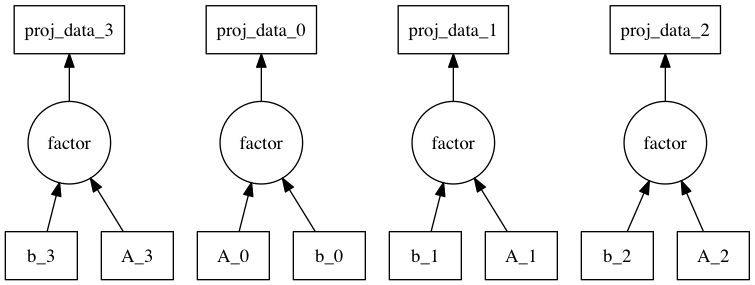

In [7]:
lAs = enum_values(As, 'A')
lbs = enum_values(bs, 'b')
proj_data = enum_map(factor, lAs, lbs, name='proj_data')

visualize(*proj_data)

- visualize one iteration

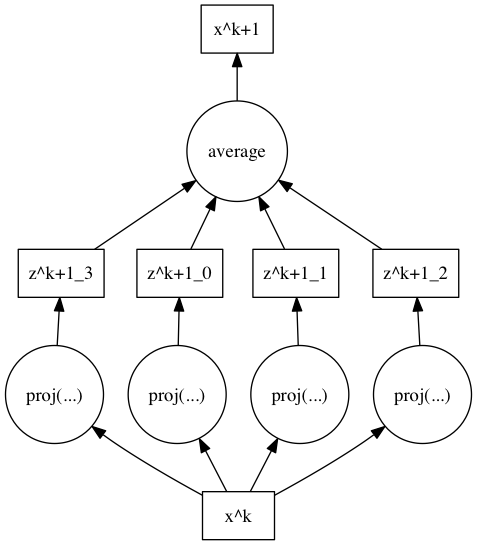

In [8]:
pd_val = [pd.compute() for pd in proj_data]

xk = value(x0,'x^k')
xkk = step(pd_val, xk)
xkk.visualize()

The setup step along with 3 iterations gives the following dask graph. (Which I'm showing mostly because it was satisfying to make.)

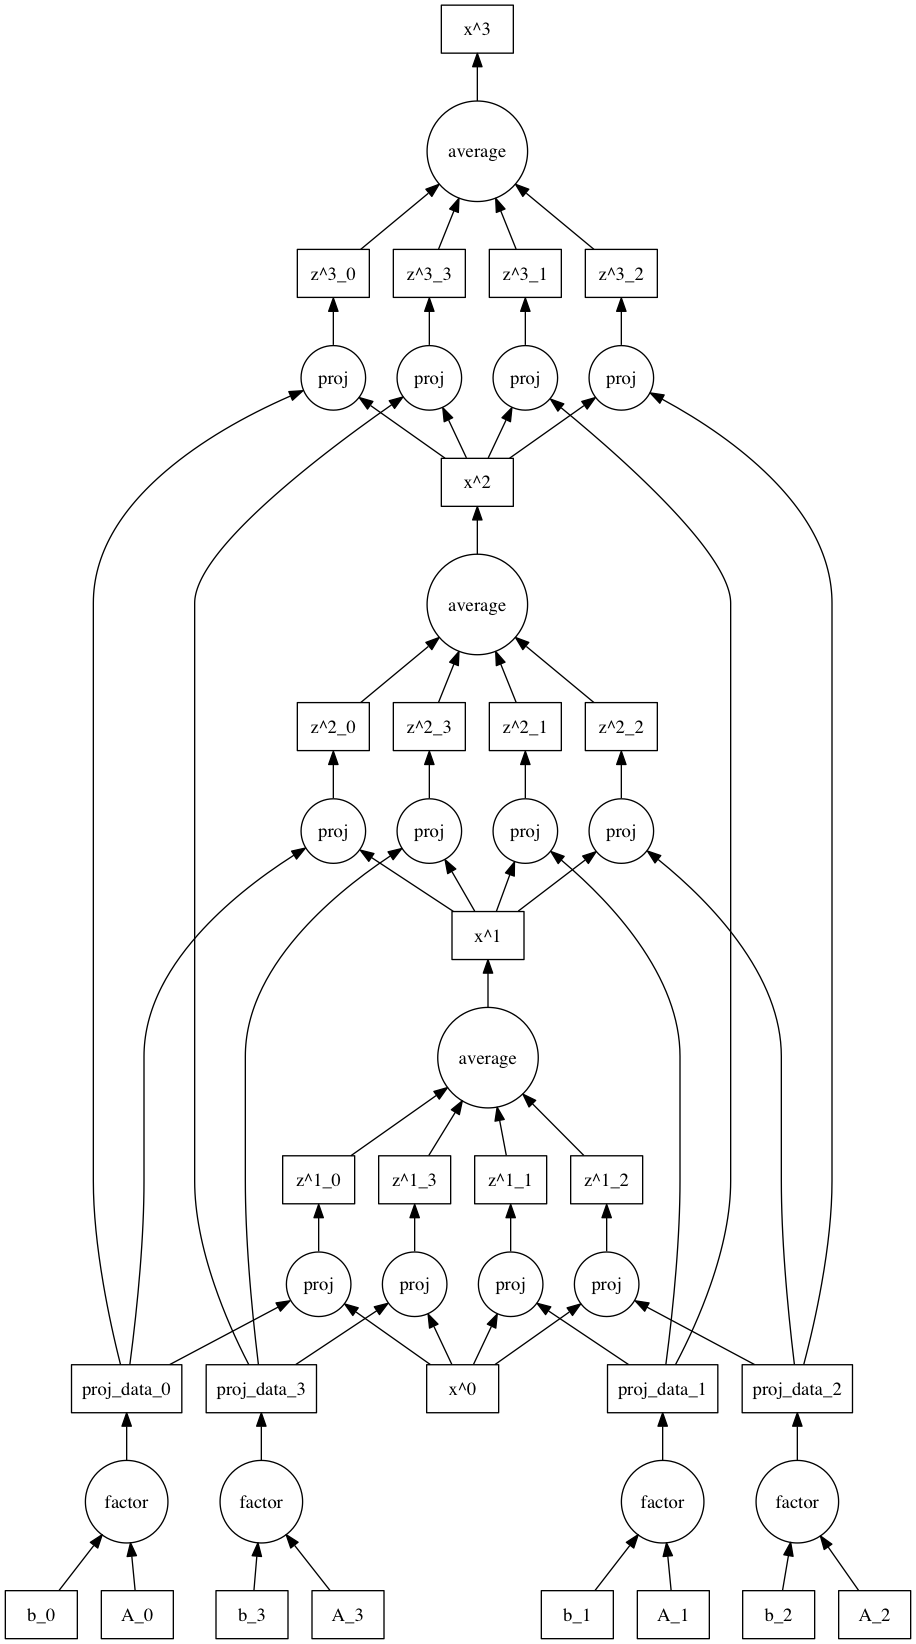

In [9]:
x = value(x0,'x^0')
for k in range(3):
    x = step(proj_data, x, k+1)
    
x.visualize()

# Reuse dask graph

Obviously, it's not efficient to make a huge dask graph, especially if I'll be doing thousands of iterations.
I really just want to create the dask graph for computing $x^{k+1}$ from $x^k$ and re-apply it at every iteration.
Is it more efficient to create that dask graph once and reuse it? Maybe that's a premature optimization... I'll do it anyway for fun.

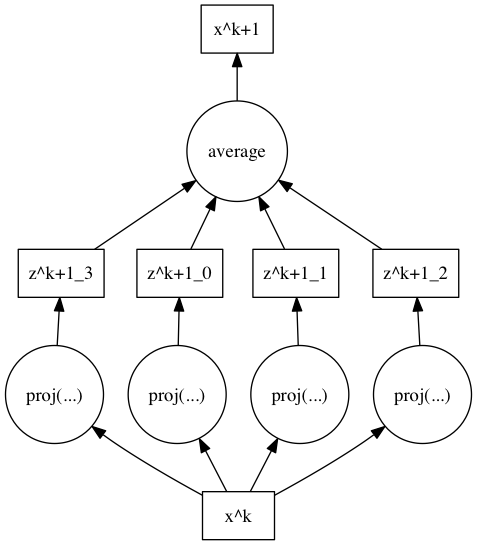

In [10]:
proj_data = enum_map(factor, As, bs, name='proj_data')
proj_data = compute(*proj_data)

x = value(0,'x^k')
x = step(proj_data, x)

dsk_step = x.dask
dot_graph(dsk_step)

In [11]:
dask.set_options(get=dask.threaded.get)     # multiple threads
#dask.set_options(get=dask.async.get_sync)   # single thread

In [12]:
%%time

# do one-time computation of factorizations
proj_data = enum_map(factor, As, bs, name='proj_data')

# realize the computations, so they aren't recomputed at each iteration
proj_data = compute(*proj_data)

# get dask graph for reuse
x = value(x0,'x^k')
x = step(proj_data, x)
dsk_step = x.dask

K = 100
r = []
for k in range(K):
    dsk_step['x^k'] = get(dsk_step, 'x^k+1')
    r.append(np.linalg.norm(x_true-dsk_step['x^k']))

CPU times: user 7.2 s, sys: 146 ms, total: 7.34 s
Wall time: 4.64 s


In [13]:
%%time
# serial execution
proj_data = list(map(factor, As, bs))

x = x0

K = 100
r = []
for i in range(K):
    z = (proj(d,x) for d in proj_data)
    x = average(*z)
    r.append(np.linalg.norm(x_true-x))

CPU times: user 6.92 s, sys: 104 ms, total: 7.03 s
Wall time: 4.46 s


# iterative projection algorithm thoughts
- I don't see any performance gain in using the threaded scheduler, but I don't see what I'm doing wrong here
- I don't see any difference in runtime switching between `dask.set_options(get=dask.threaded.get)` and `dask.set_options(get=dask.async.get_sync)`; not sure if it's actually changing the scheduler, but I haven't looked into it closely

# random Dask thoughts
- would be nice to be able to rename a `Value` and change the data that it points to
- at least for visualizing, I wanted more control over intermediate value names and the ability to enumerate those names with subscripts, which lead to my kludgy functions above. probably not a high-priority item for you tho...
- would be nice if `dask.visualize` also worked on Dask graph dictionaries, so I don't have to remember `dask.dot.dot_graph`

# Dask attempt 2
- I tried a different method for using the threaded scheduler, but got similar results

In [15]:
%%time

# do one-time computation of factorizations
proj_data = enum_map(factor, As, bs, name='proj_data')

# realize the computations, so they aren't recomputed at each iteration
proj_data = compute(*proj_data, get=dask.threaded.get, num_workers=2)

# get dask graph for reuse
x = value(x0,'x^k')
x = step(proj_data, x)
dsk_step = x.dask

K = 100
r = []
for k in range(K):
    dsk_step['x^k'] = dask.threaded.get(dsk_step, 'x^k+1', num_workers=2)
    r.append(np.linalg.norm(x_true-dsk_step['x^k']))

CPU times: user 9.34 s, sys: 813 ms, total: 10.2 s
Wall time: 4.5 s


# Runtime error
- As I was experimenting and switching schedulers and between my first and second dask attempts, I would very often get the following "can't start new thread" error
- I would also occasionally get an "TypeError: get_async() got multiple values for argument 'num_workers'" even though I had thought I'd set `dask.set_options(get=dask.threaded.get)`

In [23]:
%%time

# do one-time computation of factorizations
proj_data = enum_map(factor, As, bs, name='proj_data')

# realize the computations, so they aren't recomputed at each iteration
proj_data = compute(*proj_data)

# get dask graph for reuse
x = value(x0,'x^k')
x = step(proj_data, x)
dsk_step = x.dask

K = 100
r = []
for k in range(K):
    dsk_step['x^k'] = get(dsk_step, 'x^k+1', num_workers=2)
    r.append(np.linalg.norm(x_true-dsk_step['x^k']))

RuntimeError: can't start new thread

In [16]:
%%time

# do one-time computation of factorizations
proj_data = enum_map(factor, As, bs, name='proj_data')

# realize the computations, so they aren't recomputed at each iteration
proj_data = compute(*proj_data)

# get dask graph for reuse
x = value(x0,'x^k')
x = step(proj_data, x)
dsk_step = x.dask

K = 100
r = []
for k in range(K):
    dsk_step['x^k'] = get(dsk_step, 'x^k+1', num_workers=2)
    r.append(np.linalg.norm(x_true-dsk_step['x^k']))

TypeError: get_async() got multiple values for argument 'num_workers'

In [ ]:
np.__config__.show()

atlas_info:
  NOT AVAILABLE
atlas_threads_info:
  NOT AVAILABLE
atlas_3_10_info:
  NOT AVAILABLE
atlas_3_10_blas_info:
  NOT AVAILABLE
atlas_blas_info:
  NOT AVAILABLE
atlas_blas_threads_info:
  NOT AVAILABLE
blas_opt_info:
    extra_link_args = ['-Wl,-framework', '-Wl,Accelerate']
    define_macros = [('NO_ATLAS_INFO', 3), ('HAVE_CBLAS', None)]
    extra_compile_args = ['-msse3', '-I/System/Library/Frameworks/vecLib.framework/Headers']
openblas_info:
  NOT AVAILABLE
atlas_3_10_blas_threads_info:
  NOT AVAILABLE
atlas_3_10_threads_info:
  NOT AVAILABLE
lapack_mkl_info:
  NOT AVAILABLE
blas_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
  NOT AVAILABLE
lapack_opt_info:
    extra_link_args = ['-Wl,-framework', '-Wl,Accelerate']
    define_macros = [('NO_ATLAS_INFO', 3), ('HAVE_CBLAS', None)]
    extra_compile_args = ['-msse3']
mkl_info:
  NOT AVAILABLE
